In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import datetime
import plotly.express as px
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

<ipython-input-1-c658ec1e5d54>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
from google.colab import files
uploaded=files.upload()

Saving CocaCola_Sales_Rawdata.xlsx to CocaCola_Sales_Rawdata.xlsx


In [3]:
data=pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
data

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [4]:
data.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [6]:
data.nunique()

Quarter    42
Sales      42
dtype: int64

In [7]:
data.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [8]:
data['Quarter_Year']=data['Quarter'].str.split('_').apply(lambda x:' 19'.join(x[:]))

In [9]:
data.head()

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987


In [10]:
data['Date']=(pd.to_datetime(data['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1]))))
data.head()

,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01


In [11]:
data['Quarters']=0
for i in range(42):
  n=data['Quarter'][i]
  data['Quarters'][i]=n[0:2]

In [12]:
data.head()

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1


In [13]:
dummy=pd.DataFrame(pd.get_dummies(data['Quarters']))
data1=pd.concat((data,dummy),axis=1)
data1.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,1,0,0,0


In [14]:
data1.drop(['Quarter','Quarter_Year'],axis=1,inplace=True)
data1.head()

,Sales,Date,Quarters,Q1,Q2,Q3,Q4
0,1734.827000,1986-01-01,Q1,1,0,0,0
1,2244.960999,1986-04-01,Q2,0,1,0,0
2,2533.804993,1986-07-01,Q3,0,0,1,0
3,2154.962997,1986-10-01,Q4,0,0,0,1
4,1547.818996,1987-01-01,Q1,1,0,0,0


In [15]:
data1.set_index('Date',inplace=True)
data1.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')

In [16]:
data1.head()

,Sales,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,
1986-01-01,1734.827000,Q1,1,0,0,0
1986-04-01,2244.960999,Q2,0,1,0,0
1986-07-01,2533.804993,Q3,0,0,1,0
1986-10-01,2154.962997,Q4,0,0,0,1
1987-01-01,1547.818996,Q1,1,0,0,0


In [17]:
data['Date']=pd.to_datetime(data.Date,format='%b-%y')
data['month']=data.Date.dt.strftime('%b')#month extraction
data['year']=data.Date.dt.strftime('%Y')#year extraction
data.head(5)

,Quarter,Sales,Quarter_Year,Date,Quarters,month,year
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,1986
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,1986
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,1986
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,1986
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,1987


In [18]:
pivot_table=pd.pivot_table(data=data,values='Sales',index='year',columns='month',aggfunc='mean',fill_value=0)
pivot_table

month,Apr,Jan,Jul,Oct
year,,,,
1986,2244.960999,1734.827000,2533.804993,2154.962997
1987,2104.411995,1547.818996,2014.362999,1991.746998
1988,2313.631996,1869.049999,2128.320000,2026.828999
1989,2331.164993,1910.603996,2206.549995,2173.967995
1990,2739.307999,2148.278000,2792.753998,2556.009995
1991,3039.522995,2480.973999,3172.115997,2879.000999
1992,3550.000000,2772.000000,3508.000000,3243.859993
1993,3899.000000,3056.000000,3629.000000,3373.000000
1994,4342.000000,3352.000000,4461.000000,4017.000000


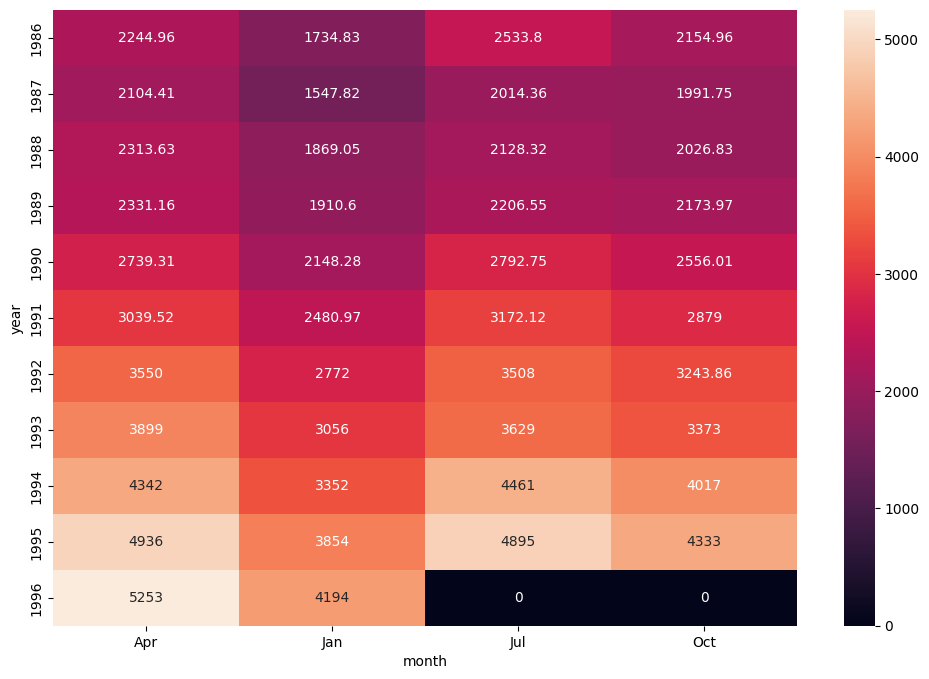

In [19]:
plt.figure(figsize=(12,8))
sns.heatmap(pivot_table,annot=True,fmt='g')
plt.show()

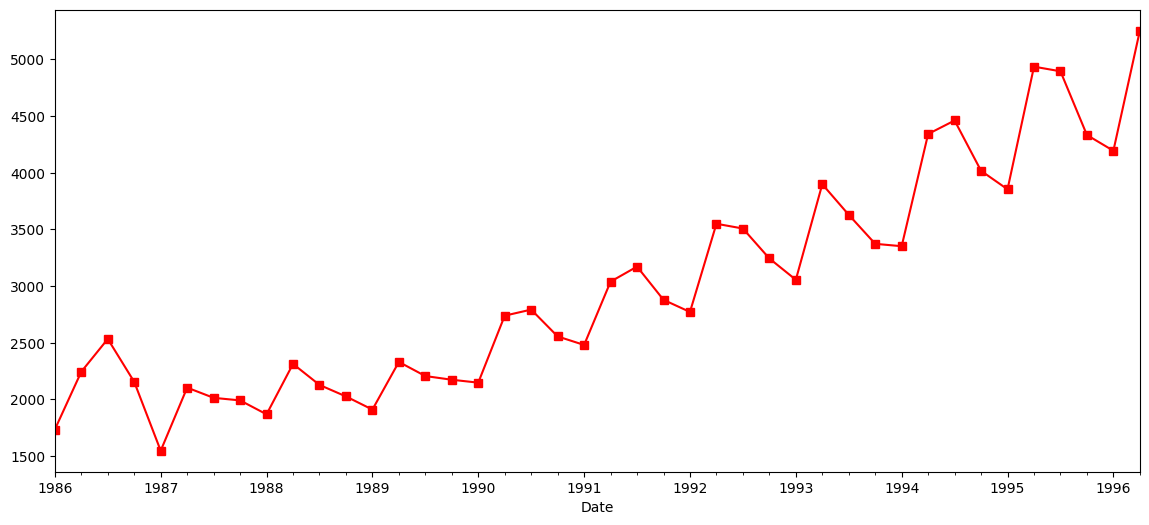

In [20]:
data1['Sales'].plot(figsize=(14,6),color='red',marker='s')
plt.show()

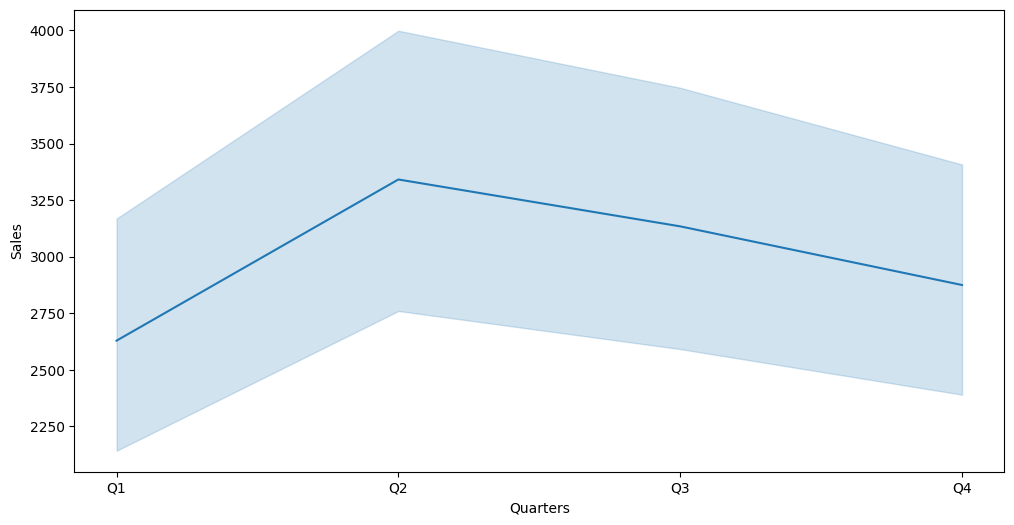

In [21]:
plt.figure(figsize=(12,6))
sns.lineplot(x='Quarters',y='Sales',data=data)
plt.show()

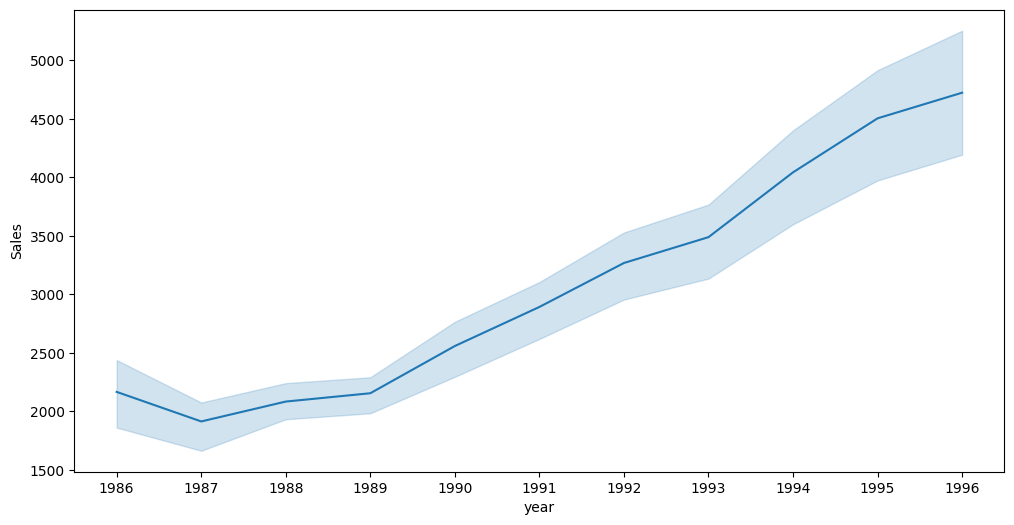

In [22]:
plt.figure(figsize=(12,6))
sns.lineplot(x='year',y='Sales',data=data)
plt.show()

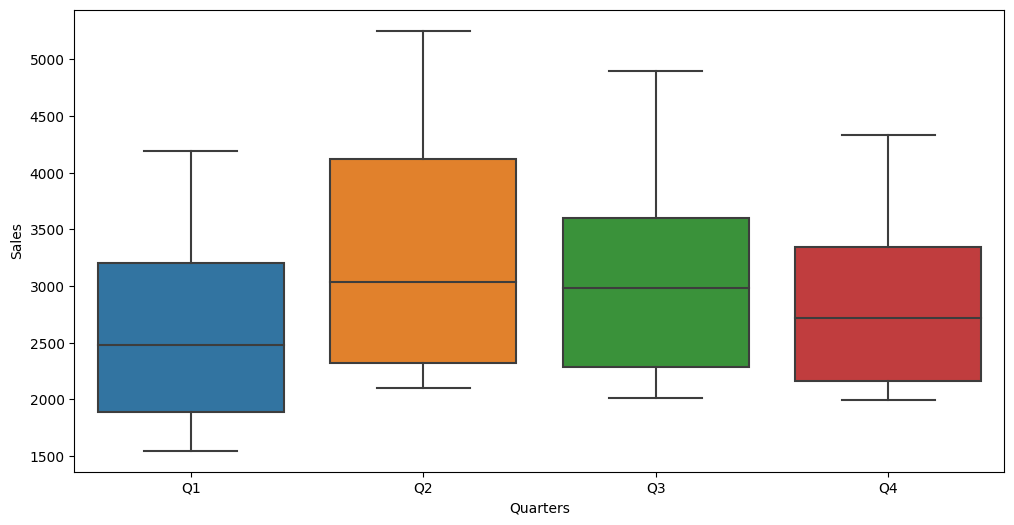

In [23]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Quarters',y='Sales',data=data)
plt.show()

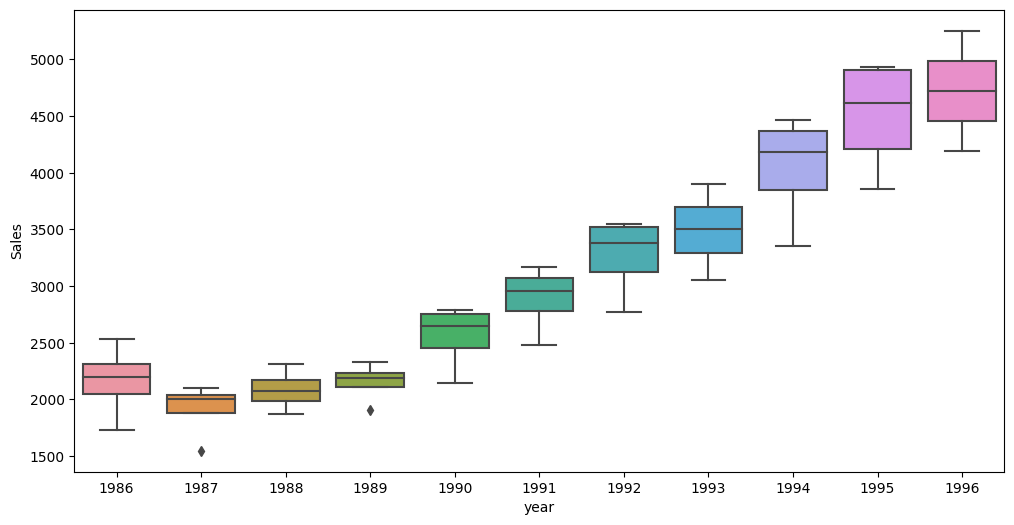

In [24]:
plt.figure(figsize=(12,6))
sns.boxplot(x='year',y='Sales',data=data)
plt.show()

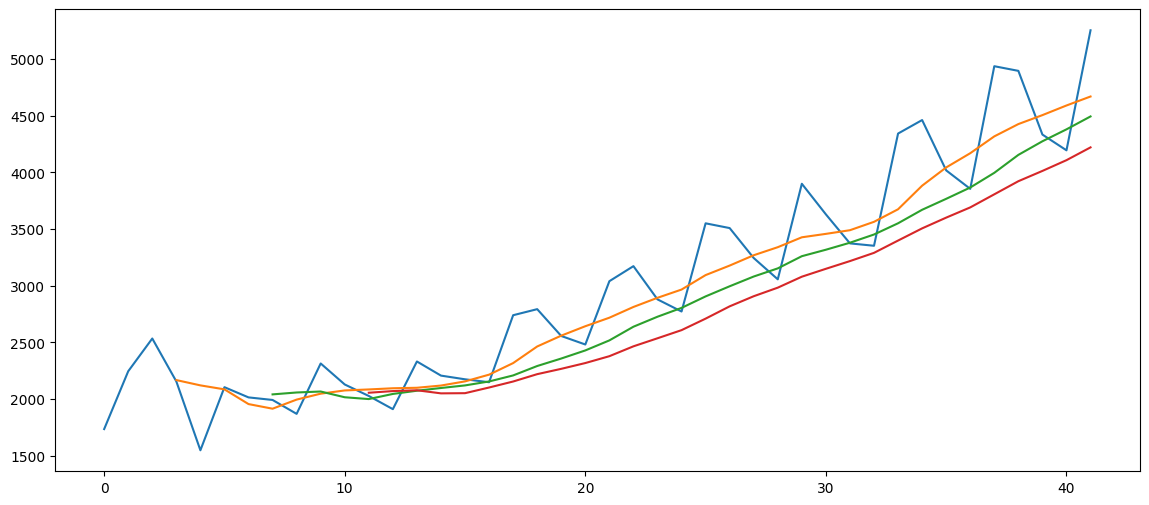

In [25]:
plt.figure(figsize=(14,6))
data.Sales.plot(label='org')
for i in range (4,13,4):
  data['Sales'].rolling(i).mean().plot(label=str(i))

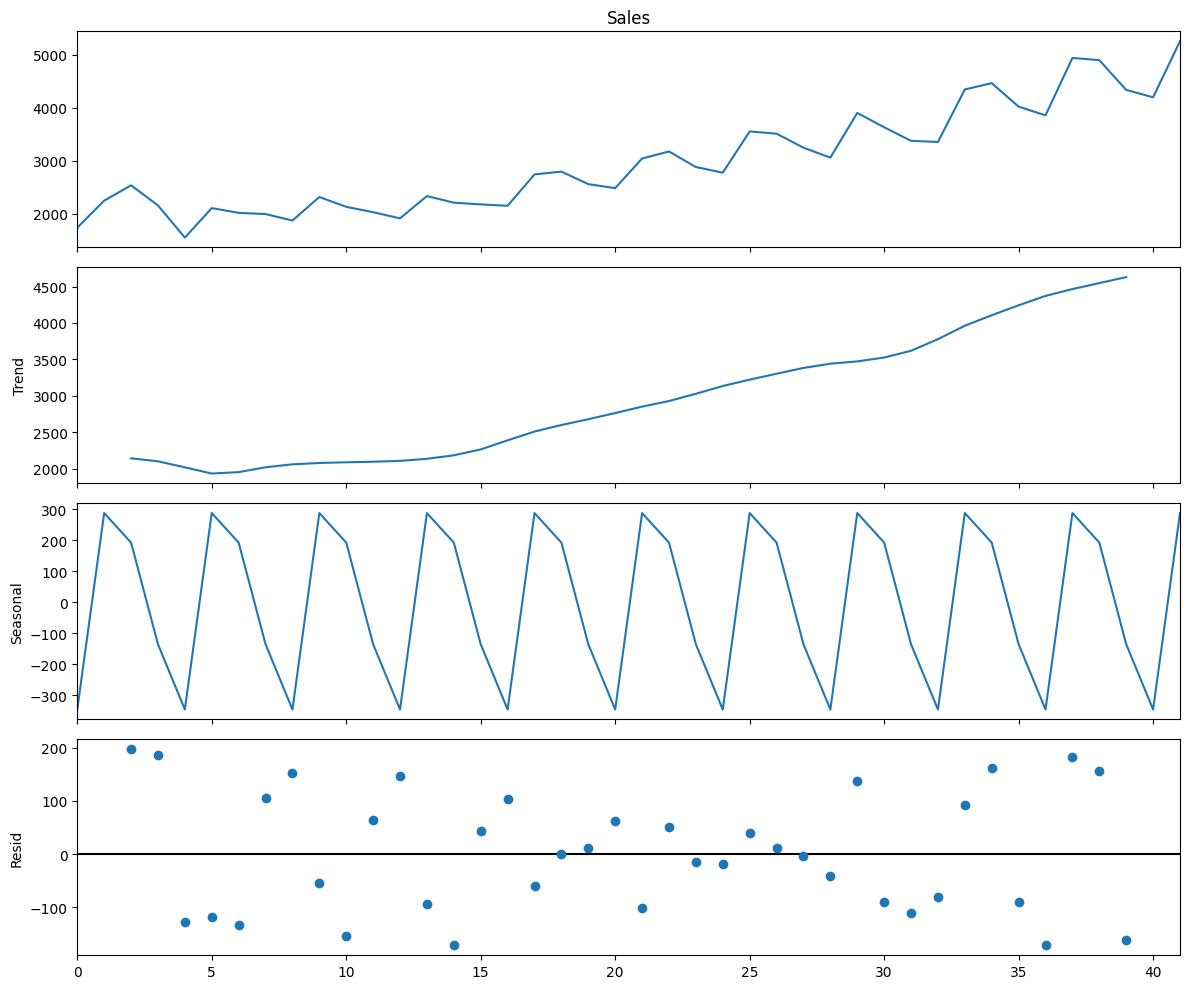

In [26]:
decompose_ts_add=seasonal_decompose(data.Sales,period=4)
with plt.rc_context():
  plt.rc('figure',figsize=(12,10))
  decompose_ts_add.plot()
  plt.show()

In [27]:
upsampled_month=data1.drop(['Quarters','Q1','Q2','Q3','Q4'],axis=1)
upsampled_month=upsampled_month.resample('M').mean()
print(upsampled_month.head())

                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN


In [28]:
interpolated_month=upsampled_month.interpolate(method='linear')
print(interpolated_month.head())

                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330


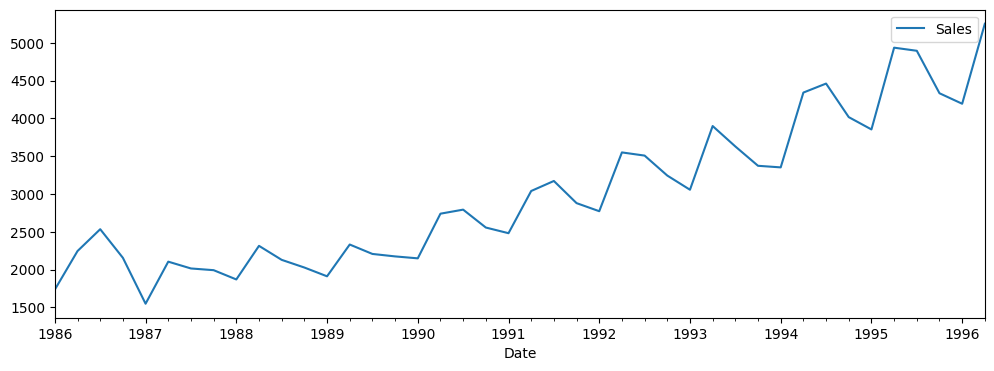

In [29]:
interpolated_month.plot(figsize=(12,4))
plt.show()

In [30]:
interpolated_month

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


In [31]:
train_data=interpolated_month[:100]
test_data=interpolated_month[100:]

In [32]:
interpolated_month.reset_index(inplace=True)
interpolated_month['t'] = np.arange(1,len(interpolated_month)+1)
interpolated_month['t_squared'] = np.square(interpolated_month.t)
interpolated_month["month"] = interpolated_month.Date.dt.strftime("%b") # month extraction
interpolated_month["year"] = interpolated_month.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(interpolated_month['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([interpolated_month,months],axis=1)
cocacola['log_sales'] = np.log(cocacola['Sales'])
cocacola

,Date,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1995-12-31,4240.333333,120,14400,Dec,1995,0,0,0,0,0,0,0,0,0,0,0,1,8.352397
120,1996-01-31,4194.000000,121,14641,Jan,1996,1,0,0,0,0,0,0,0,0,0,0,0,8.341410
121,1996-02-29,4547.000000,122,14884,Feb,1996,0,1,0,0,0,0,0,0,0,0,0,0,8.422223
122,1996-03-31,4900.000000,123,15129,Mar,1996,0,0,1,0,0,0,0,0,0,0,0,0,8.496990


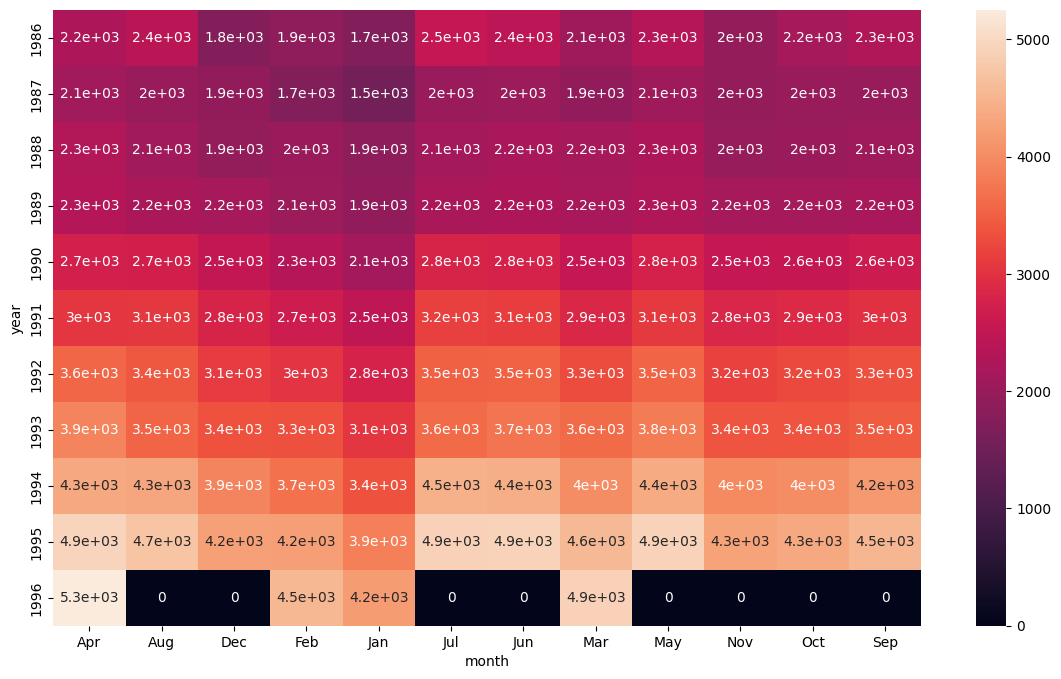

In [33]:
plt.figure(figsize=(14,8))
heatmap_y_month=pd.pivot_table(data=cocacola,values='Sales',index='year',columns='month',aggfunc='mean',fill_value=0)
sns.heatmap(heatmap_y_month,annot=True)
plt.show()

In [34]:
size=100
train_data=cocacola.iloc[:size]
test_data=cocacola.iloc[size:]

In [35]:
train_data

,Date,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1993-12-31,3359.000000,96,9216,Dec,1993,0,0,0,0,0,0,0,0,0,0,0,1,8.119399
96,1994-01-31,3352.000000,97,9409,Jan,1994,1,0,0,0,0,0,0,0,0,0,0,0,8.117312
97,1994-02-28,3682.000000,98,9604,Feb,1994,0,1,0,0,0,0,0,0,0,0,0,0,8.211211
98,1994-03-31,4012.000000,99,9801,Mar,1994,0,0,1,0,0,0,0,0,0,0,0,0,8.297045


In [36]:
test_data

,Date,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
100,1994-05-31,4381.666667,101,10201,May,1994,0,0,0,0,1,0,0,0,0,0,0,0,8.385184
101,1994-06-30,4421.333333,102,10404,Jun,1994,0,0,0,0,0,1,0,0,0,0,0,0,8.394197
102,1994-07-31,4461.000000,103,10609,Jul,1994,0,0,0,0,0,0,1,0,0,0,0,0,8.403128
103,1994-08-31,4313.000000,104,10816,Aug,1994,0,0,0,0,0,0,0,1,0,0,0,0,8.369389
104,1994-09-30,4165.000000,105,11025,Sep,1994,0,0,0,0,0,0,0,0,1,0,0,0,8.334472
105,1994-10-31,4017.000000,106,11236,Oct,1994,0,0,0,0,0,0,0,0,0,1,0,0,8.298291
106,1994-11-30,3962.666667,107,11449,Nov,1994,0,0,0,0,0,0,0,0,0,0,1,0,8.284672
107,1994-12-31,3908.333333,108,11664,Dec,1994,0,0,0,0,0,0,0,0,0,0,0,1,8.270866
108,1995-01-31,3854.000000,109,11881,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,8.256867
109,1995-02-28,4214.666667,110,12100,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,8.346326


In [37]:
from scipy import stats
import statsmodels.formula.api as smf

In [38]:
linear_model=smf.ols('Sales~t',data=train_data).fit()
pred_linear=pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear=np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_linear))**2))
rmse_linear

686.8740863668942

In [39]:
exp_model=smf.ols('log_sales~t',data=train_data).fit()
pred_exp=pd.Series(exp_model.predict(pd.DataFrame(test_data['t'])))
rmse_exp=np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_linear))**2))
rmse_exp

686.8740863668942

In [40]:
add_sea=smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea=pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea=np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1837.7879723483793

In [41]:
mul_sea=smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_mul_sea=pd.Series(mul_sea.predict(test_data))
rmse_mul_sea=np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_mul_sea))**2))
rmse_mul_sea

4462.008204384481